<a href="https://colab.research.google.com/github/eomtaehyeon/kaggle/blob/main/newbie_s_catboost_spaceship_titanic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 - AI데이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : Spaceship Titanic 데이터를 활용한 탑승유무 분류모형 개발
- 프로젝트 마감일 : 2022년 4월 12일 화요일
- 수강생명 : 엄태현

# Loading Libraries And Data

## Libraies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import sklearn
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix



print("Version Pandas", pd.__version__)
print("Version Matplotlib", matplotlib.__version__)
print("Version Numpy", np.__version__)
print("Version Seaborn", sns.__version__)
print("Version Sklearn",sklearn.__version__)

Version Pandas 1.3.5
Version Matplotlib 3.5.1
Version Numpy 1.20.3
Version Seaborn 0.11.2
Version Sklearn 1.0.1


## Data

- train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
- test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test
- sample_submission.csv - A submission file in the correct format.
    + PassengerId - Id for each passenger in the test set.
    + Transported - The target. For each passenger, predict either True or False.


In [ ]:
train = pd.read_csv("../input/spaceship-titanic/train.csv")
test = pd.read_csv("../input/spaceship-titanic/test.csv")
submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

## Feature descriptions: 

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

    - Reference : https://www.kaggle.com/competitions/spaceship-titanic/data


## Check Train Data

In [ ]:
# Train Data shape

print('Train Data Shape :', train.shape)

Train Data Shape : (8693, 14)


In [ ]:
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


- 행 : 8693개, 열 : 14개 , 값 : 119378개, 결측치 : 2324개
- CryoSleep이 217개로 결측값이 가장 많습니다.
- PassengerId, Transported 를 제외하고 179개 이상의 결측값을 가지고 있습니다.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
print('Train Data total missing values :', sum(train.isna().sum()))
print('')
print('Train Data missing values :')
print(train.isna().sum().sort_values(ascending = False))


Train Data total missing values : 2324

Train Data missing values :
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [ ]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

## Check Test Data
- Transported 값은 훈련데이터에만 있습니다.

In [ ]:
# Test Data shape

print('Test Data shape :', test.shape)

Test Data shape : (4277, 13)


In [ ]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


- 행 : 4277개, 열 : 13개, 값 : 54484개, 결측값 : 1117개
- FoodCourt가 결측값이 106개로 가장 많습니다.
- PassengerId 를 제외하고 80개 이상 결측값을 가지고 있습니다.

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [ ]:
print('Test Data total missing values :', sum(test.isna().sum()))
print('')
print('Test Data missing vlues :')
print(test.isna().sum().sort_values(ascending = False))


Test Data total missing values : 1117

Test Data missing vlues :
FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


# EDA

 ## Cardinality of features
 
 - Target Features : Transported
 - Continuous Features : Age, Roomservice, Foodcourt, ShoppingMall, Spa, VRDeck
 - Categorical Features : HomePlanet, CryoSleep, Destination, VIP
 - descriptive/qualitative features : PassengerId, Cabin, Name


### Target Feature
- Transported 값은 True : 50.4% , False : 49.6% 로 나타난다.(Train Data만 있음.)

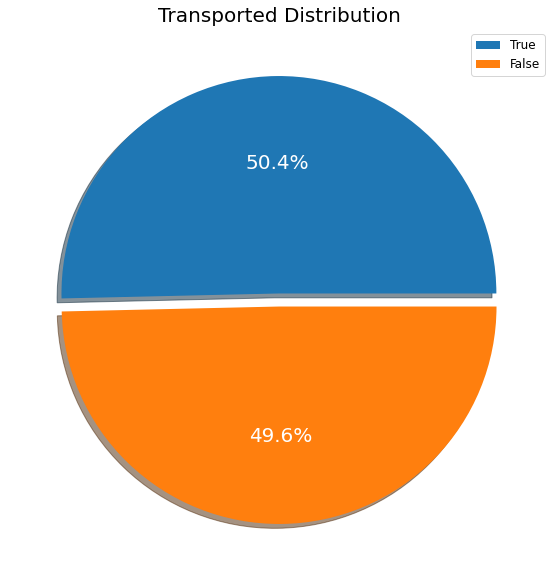

In [ ]:
# Transported 값의 True 와 False 값

plt.subplots(figsize=(20, 10))
plt.pie(train.Transported.value_counts(), shadow=True, explode=[.03,.03], autopct='%1.1f%%',
        textprops={'fontsize': 20, 'color': 'white'})
plt.title('Transported Distribution', size=20)
plt.legend(['True', 'False'], loc='best', fontsize=12)
plt.show()

## Categorical Features
- HomePlanet에서 Earth에서 False 값이 가장 많고, 다음으로 True 값이 많습니다.
- Cryosleep에서 False에서 False 값이 가장 많고, 다음으로 True 에서 True 값이 많습니다.
- Destination에서 TRAPPIST-1e 에서 False 값이 가장 많고, 다음으로 True 값이 많습니다.
- VIP에서 False와 True 값이 상반되게 보여지고 있습니다. 

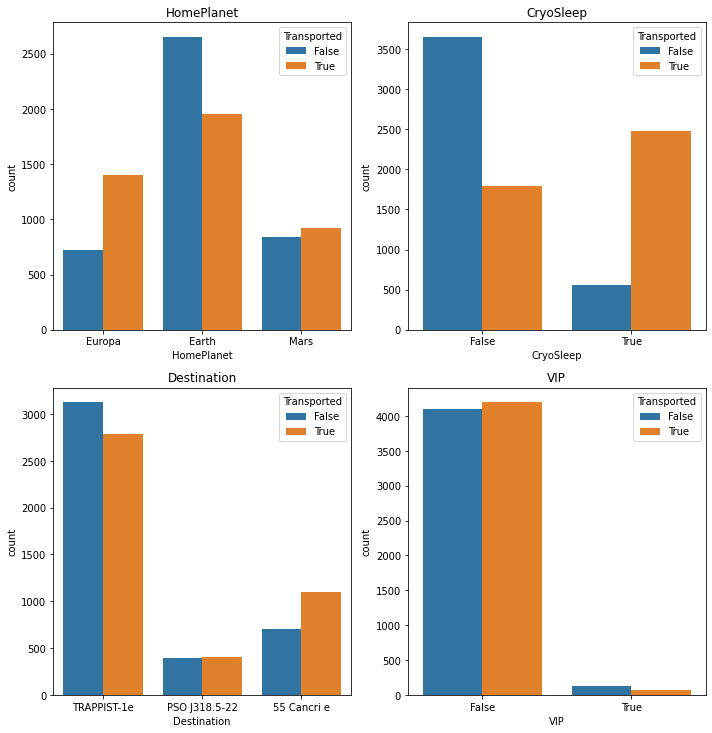

In [ ]:
# Categoricl features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,2,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

## Continuous features
- Continuous features 중 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'를 Expenditure features로 묶었습니다.
- Expenditure features 값은 공통적으로 0 값이 많습니다.
- Age는 20~40대 비율이 많습니다.

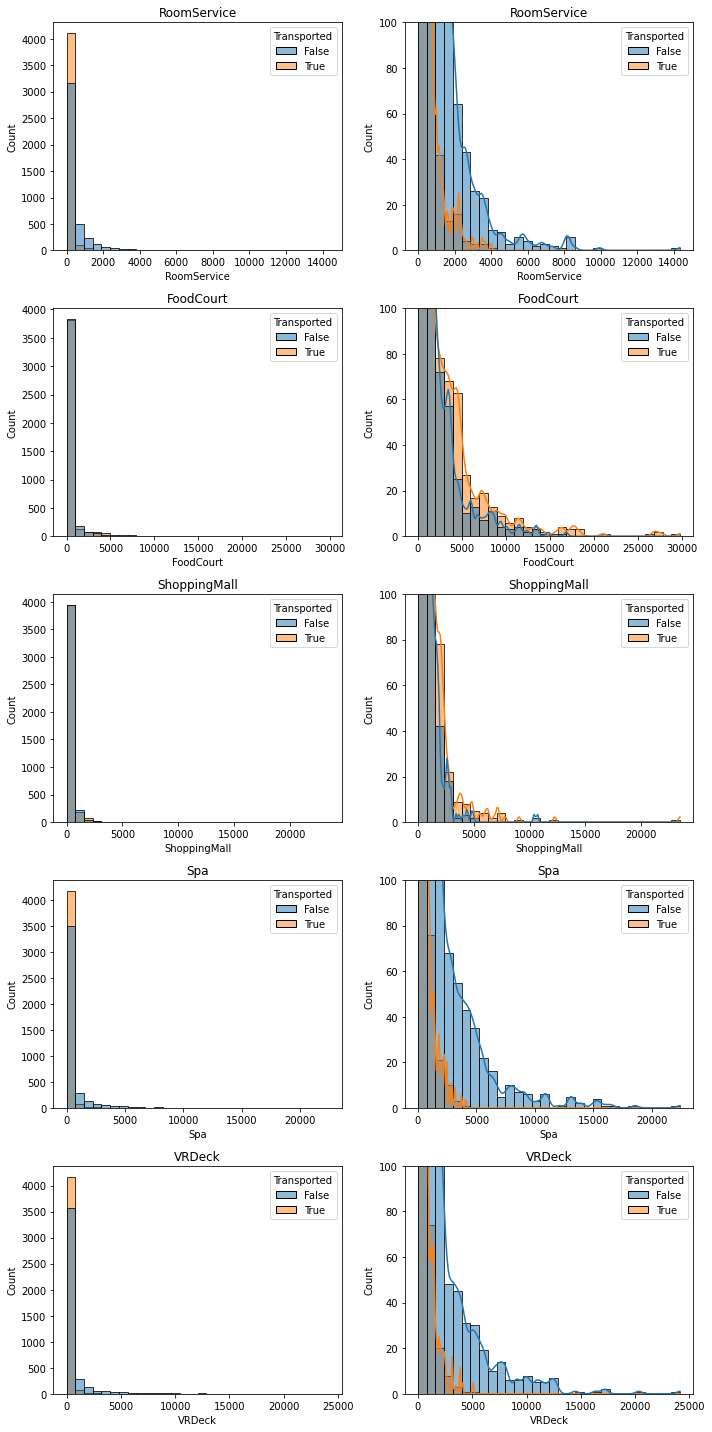

In [ ]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

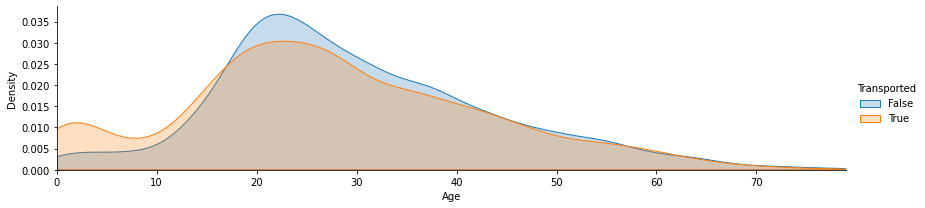

In [ ]:
facet = sns.FacetGrid(train, hue="Transported", aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.show()

## Qualitative features
- PassengerId는 그룹과 번호로 나누어서 분석할 필요가 있습니다.
- Cabin은 갑판/번호/사이드로 나누어서 분석할 필요가 있습니다.
- Name은 성이 같은 사람끼리 가족구성원으로 생각하여 가족구성원이 몇명인지 분석해봐야 합니다.

In [ ]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


# Data Preprocessing 
- Feature Engineering
- ML 모형을 돌리기 위해 표준화 등 / 원핫-인코딩
- 파생변수 (도출 변수)
    + 왜 이 변수를 만들었는지에 대한 설명 필요

## Missing Values 
- Continuous features 는 중간값을 이용. age는 3 그룹정도로 나누고, 시설이용료는 다른 그룹화를 하는 것이 좋습니다.
- Categorical features는 빈번한 쪽으로 처리하는게 좋을 것 같습니다.
- PassengerId를 통해 그룹별로 나누고 번호를 통해 혼자인지, 아닌지를 판별하기 좋습니다.
- Cabin을 통해 Deck/Number/Side 별로 나눠서 그룹화 하여 판별하기 좋습니다.


### Continuous data
- describe() 를 이용하면 count, mean, std, min, 25%, 50%, 75%, max 값인 기본통계량을 알 수 있습니다.

In [ ]:
print(train.describe())
print(test.describe())

               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  4186.000000   

In [ ]:
# Impute median (for continuous data)
train["Age"].fillna(train["Age"].median(), inplace=True)
test["Age"].fillna(train["Age"].median(), inplace=True) 
train["FoodCourt"].fillna(train["FoodCourt"].median(), inplace=True)
test["FoodCourt"].fillna(train["FoodCourt"].median(), inplace=True) 
train["ShoppingMall"].fillna(train["ShoppingMall"].median(), inplace=True)
test["ShoppingMall"].fillna(train["ShoppingMall"].median(), inplace=True) 
train["Spa"].fillna(train["Spa"].median(), inplace=True)
test["Spa"].fillna(train["Spa"].median(), inplace=True) 
train["VRDeck"].fillna(train["VRDeck"].median(), inplace=True)
test["VRDeck"].fillna(train["VRDeck"].median(), inplace=True) 
train["RoomService"].fillna(train["RoomService"].median(), inplace=True)
test["RoomService"].fillna(train["RoomService"].median(), inplace=True) 


### Categorical data
- mode() 를 이용하면 빈도가 많은 값을 알 수 있습니다.
- 'HomePlanet','CryoSleep','Destination','VIP' 는 가장 빈번한값으로 처리하였습니다.

In [ ]:
# mode()를 사용하여 빈번한 값을 찾았다.
train[['HomePlanet','CryoSleep','Destination','VIP']].mode()

,HomePlanet,CryoSleep,Destination,VIP
0,Earth,False,TRAPPIST-1e,False


In [ ]:
# 빈번한 값으로 대체
train['HomePlanet'].fillna('Earth', inplace=True)
test['HomePlanet'].fillna('Earth', inplace=True)

train['CryoSleep'].fillna(False, inplace=True)
test['CryoSleep'].fillna(False, inplace=True)

train['Destination'].fillna('TRAPPIST-1e', inplace=True)
test['Destination'].fillna('TRAPPIST-1e', inplace=True)

train['VIP'].fillna(False, inplace=True)
test['VIP'].fillna(False, inplace=True)


### Qualitative data
- Qualitative data는 새로운 값으로 지정하였습니다.

In [ ]:
# Impute outliers (for qualitative data)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

train['Name'].fillna('No Name', inplace=True)
test['Name'].fillna('No Name', inplace=True)

In [ ]:
print('Train Data values:')
print(train.isna().sum().sort_values(ascending = False))
print("")
print('Test Data values:')
print(test.isna().sum().sort_values(ascending = False))

Train Data values:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

Test Data values:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64


## Feature Engineering

### Age Status
- 0 ~ 20세, 20 ~ 40세, 41세 이상 으로 그룹화 하였습니다.

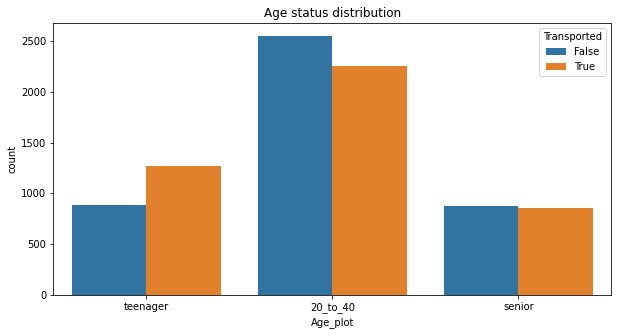

In [ ]:
# New features - training set
train['teenager']=(train['Age']<20).astype(int)
train['20_to_40']=((train['Age']>=20) & (train['Age']<=40)).astype(int)
train['senior']=(train['Age']>40).astype(int)

# New features - test set
test['teenager']=(test['Age']<20).astype(int)
test['20_to_40']=((test['Age']>=20) & (test['Age']<=40)).astype(int)
test['senior']=(test['Age']>40).astype(int)

# Plot distribution of new features
train['Age_plot']=train['teenager']+2*train['20_to_40']+3*train['senior']
plt.figure(figsize=(10,5))
g=sns.countplot(data=train, x='Age_plot', hue='Transported')
plt.title('Age status distribution')
g.set_xticklabels(['teenager', '20_to_40', 'senior'])
train.drop('Age_plot', axis=1, inplace=True)

### Expenditure Status
- Expenditure Features 갑을 다 더하여서 0과 1로 그룹화를 하였습니다.


Text(0.5, 1.0, 'No spending indicator')

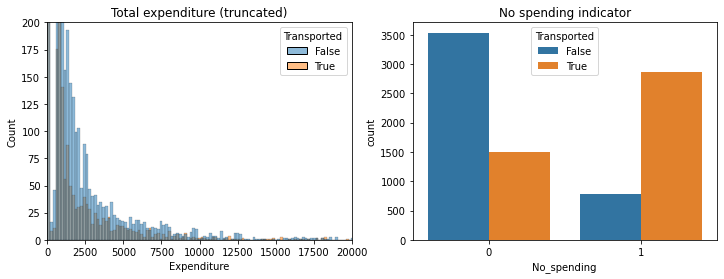

In [ ]:
# New features - training set
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

# Plot distribution of new features
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')

### Passenger group
    - PassengerId에서 승객 그룹 및 그룹 크기를 추출하였습니다.

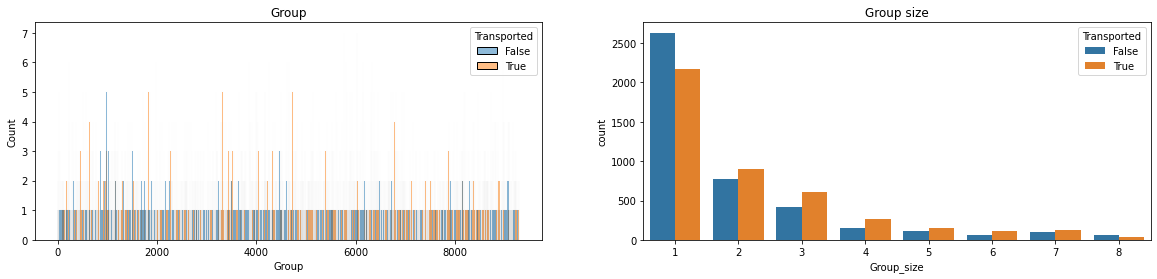

In [ ]:
# New features - training set
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
train['Group_size']=train['Group'].map(lambda x: train['Group'].value_counts()[x])

# New features - test set
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group_size']=test['Group'].map(lambda x: test['Group'].value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

- 그룹 사이즈를 통해 혼자인 사람과 아닌사람을 나눴습니다.

(0.0, 3000.0)

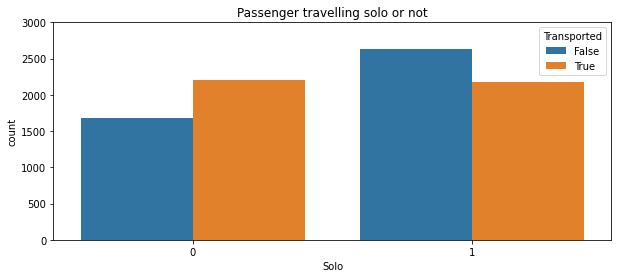

In [ ]:
# New feature
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

### Cabin location
- Cabin을 갑판/ 번호 / 사이드 값으로 나눴습니다.
- 번호 값을 300으로 나눠 다시 그룹화 하였습니다.

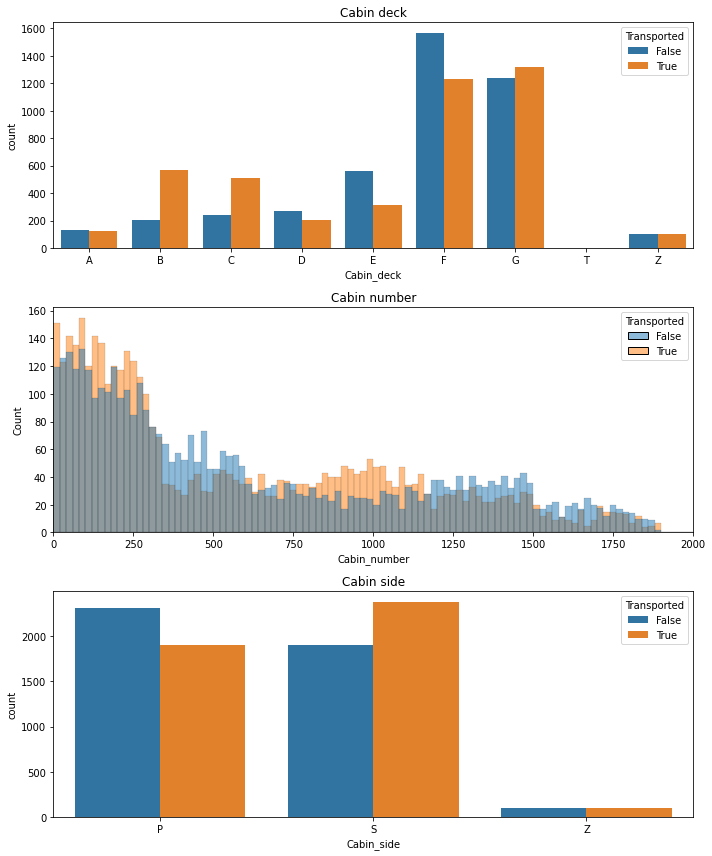

In [ ]:
# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T','Z'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

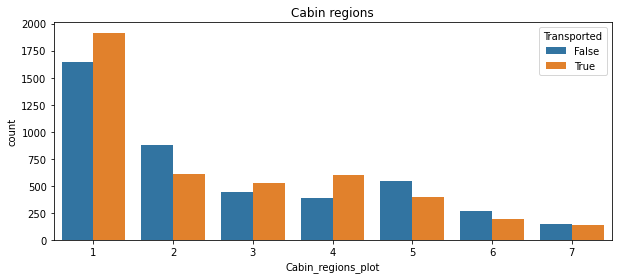

In [ ]:
# New features - training set
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

# New features - test set
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

### Last name
- Name의 성으로 Family_sizy 그룹화 하였습니다.

Text(0.5, 1.0, 'Family size')

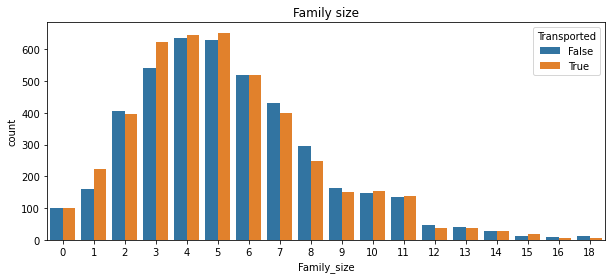

In [ ]:
# New features - training set
train['Surname']=train['Name'].str.split().str[-1]
train['Family_size']=train['Surname'].map(lambda x: train['Surname'].value_counts()[x])

# New features - test set
test['Surname']=test['Name'].str.split().str[-1]
test['Family_size']=test['Surname'].map(lambda x: test['Surname'].value_counts()[x])

# Set outliers (no name) to have no family
train.loc[train['Family_size']==200,'Family_size']=0
test.loc[test['Family_size']==200,'Family_size']=0

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

### Drop unwanted features
- 세부적으로 그룹화를 진행한 칼럼을 없앴습니다.

In [ ]:
# Drop qualitative/redundant/high cardinality features
train.drop(['PassengerId', 'Cabin', 'Name', 'Surname', 'Group', 'Cabin_number'], axis=1, inplace=True)
test.drop(['PassengerId', 'Cabin', 'Name', 'Surname', 'Group', 'Cabin_number'], axis=1, inplace=True)

# Preview resulting training set
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_deck,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Family_size
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,B,P,1,0,0,0,0,0,0,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,F,S,1,0,0,0,0,0,0,4
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,A,S,1,0,0,0,0,0,0,6
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,A,S,1,0,0,0,0,0,0,6
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,F,S,1,0,0,0,0,0,0,6


### Reference : 
- SAMUEL CORTINHAS  . Spaceship Titanic: A complete guide : https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide#EDA

## One-Hot Encoding
- 머신러닝에선 문자열을 사용할 수 없기 때문에 get_dummies를 이용해 원핫인코딩을 진행하였습니다.

In [ ]:
 def dummy_data(data, columns):
        for column in columns:
            data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
            data = data.drop(column, axis=1)
        return data
    
dummy_columns = ['HomePlanet','Destination','Cabin_deck','Cabin_side']
train = dummy_data(train, dummy_columns)
test = dummy_data(test, dummy_columns)
train['Transported'] = train['Transported'].map({True: 1, False: 0})
train['CryoSleep'] = train['CryoSleep'].map({True: 1, False: 0})
train['VIP'] = train['VIP'].map({True: 1, False: 0})


- 결측치 확인을 해줍니다. 주석처리하였습니다.

In [ ]:
# Check Encoding
# print(train.info())
# print("")
# print(test.info())

# Machine Learning
- CatBoostClassifier
- HistGradientBoostingClassifier 
- XGBoost
- LightGBM

In [ ]:
# CatBoostClassifier 
# iterations = None으로 지정

from catboost import CatBoostClassifier

cb = CatBoostClassifier(iterations= None, task_type= 'CPU')
cb

### Reference : 
- GEUNHO YU. [Pycaret] Visualization + Optimization (0.81). https://www.kaggle.com/code/arootda/pycaret-visualization-optimization-0-81#%F0%9F%93%8C-Ensemble
- Catboost 주요 개념과 특징 이해하기. https://dailyheumsi.tistory.com/136

In [ ]:
# HistGradientBoostingClassifier

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
hgb


HistGradientBoostingClassifier(random_state=42)

In [ ]:
# XGBoost

from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='hist', random_state=42)
xgb


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method='hist',
              validate_parameters=None, verbosity=None)

In [ ]:
# LightGBM

from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
lgb


LGBMClassifier(random_state=42)

# Model Evaluation
- 검증 점수 : cb > lgb > hgb > xgb(과대적합)
- 정확도 : cb > xgb > hgb > lgb

## Train Test Split


In [ ]:

X_cols = test.columns
X = train[X_cols].to_numpy()
y = train['Transported'].to_numpy()


In [ ]:

# train_test_split 를 이용하여 훈련데이터세트와 검증데이터세트를 만듬.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape


((6085, 41), (2608, 41), (6085,), (2608,))

## CatBoostClassifier
- train Acc. 0.895480690221857
- test Acc. 0.819227608874281
- Acc.  0.803680981595092

In [ ]:
# CatBoostClassifier

# Output이 너무 길어 주석처리함.
'''
scores = cross_validate(cb, X_train, y_train, return_train_score = True)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))
'''

'\nscores = cross_validate(cb, X_train, y_train, return_train_score = True)\n\nprint("train Acc.", np.mean(scores[\'train_score\']))\nprint("test Acc.", np.mean(scores[\'test_score\']))\n'

In [ ]:
# CatBoostClassifier

cb.fit(X_train, y_train, verbose=False)
y_pred = cb.predict(X_val)
print("Acc. :", accuracy_score(y_val, y_pred))


Acc. : 0.803680981595092


## HistGradientBoostingClassifier
- 훈련 평균점수 : 0.9079704190632704
- 검증 평균점수 : 0.8108463434675433
- 검증 정확도 : 0.8017638036809815

In [ ]:
# HistGradientBoostingClassifier

splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
scores = cross_validate(hgb, X_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))


train Acc. 0.9079704190632704
test Acc. 0.8108463434675433


In [ ]:
# HistGradientBoostingClassifier

hgb.fit(X_train, y_train)
y_pred = hgb.predict(X_val)
print("Acc. :", accuracy_score(y_val, y_pred))


Acc. : 0.8017638036809815


## XGBoost
- 훈련 평균점수 : 0.9539441248972885
- 검증 평균점수 : 0.8060805258833197
- 검증 정확도 : 0.8029141104294478
- 과대적합에 가깝습니다.

In [ ]:
# XGBoost

scores = cross_validate(xgb, X_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))


[07:01:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:01:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:01:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:01:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [ ]:
# XGBoost

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
print("Acc. :", accuracy_score(y_val, y_pred))


[07:01:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acc. : 0.8029141104294478


## LightGBM
- 훈련 평균점수 : 0.9116269515201315
- 검증 평균점수 : 0.8121610517666392
- 검증 정확도 : 0.8009969325153374

In [ ]:
# LightGBM

scores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))


train Acc. 0.9116269515201315
test Acc. 0.8121610517666392


In [ ]:
# LightGBM

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
print("Acc. :", accuracy_score(y_val, y_pred))


Acc. : 0.8009969325153374


# Confusion Matrix
- 실제값과 예측값이 동일하면 T (True), 틀리면 F (False)로 표시한다.
- 예측값을 기준으로 따라 Positive로 예측했다면 P, Negative로 예측했다면 N을 붙여준다.
- Accuracy = (TP+TN) / (TP+FP+TN+FN)
- TPR = True Positive Rate = Recall(재현율) = Senstivity(민감도)
- FNR = False Negative Rate
- FPR = False Positive Rate
- TNR = True Negative Rate = Specivity(특이도)
- PPV = Positive Predictive Value = Precision(정밀도)
- FDR = False Discovery Rate
- FOR = False Omission Rate
- NPV = Negative Predictive Value
- F1-score(조화평균) = 2 / (1/Precision + 1/Recall) = 2 * (Precision*Recall) / (Precision+Recall)

[07:01:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


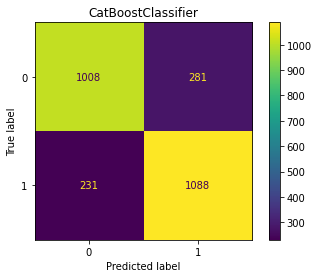

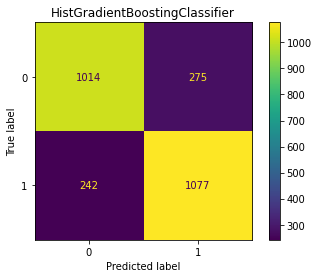

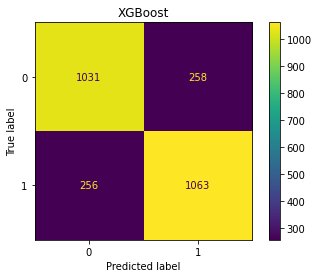

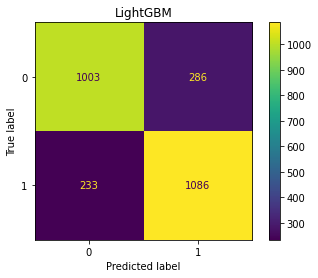

In [ ]:
# CatBoostClassifier
cb.fit(X_train, y_train, verbose=False)
plot_confusion_matrix(cb, X_val, y_val)  
plt.title('CatBoostClassifier')

# HistGradientBoostingClassifier
hgb.fit(X_train, y_train)
plot_confusion_matrix(hgb, X_val, y_val)  
plt.title('HistGradientBoostingClassifier')

# XGBoost
xgb.fit(X_train, y_train)
plot_confusion_matrix(xgb, X_val, y_val)  
plt.title('XGBoost')

# LightGBM
lgb.fit(X_train, y_train)
plot_confusion_matrix(lgb, X_val, y_val)  
plt.title('LightGBM')

plt.show()


# Comparison
    - Accuracy : CatBoostClassifier > XGBoost > HistGradientBoostingClassifier > LightGBM
    - Precision : XGBoost > HistGradientBoostingClassifier > CatBoostClassifier > LightGBM
    - Recall : CatBoostClassifier > LightGBM> HistGradientBoostingClassifier > XGBoost
    - F1-score : CatBoostClassifier > LightGBM> HistGradientBoostingClassifier > XGBoost


In [ ]:
# CatBoostClassifier
cb.fit(X_train, y_train, verbose=False)
y_pred = cb.predict(X_val)
print('CatBoostClassifier')
print("Acc. :", accuracy_score(y_val, y_pred))
print("Prec. :", precision_score(y_val, y_pred))
print('Recall :', recall_score(y_val, y_pred))
print('f1. :', f1_score(y_val, y_pred))
print('')
# HistGradientBoostingClassifier
hgb.fit(X_train, y_train)
y_pred = hgb.predict(X_val)
print('HistGradientBoostingClassifier')
print("Acc. :", accuracy_score(y_val, y_pred))
print("Prec. :", precision_score(y_val, y_pred))
print('Recall :', recall_score(y_val, y_pred))
print('f1. :', f1_score(y_val, y_pred))
print('')
# XGBoost
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
print('XGBoost')
print("Acc. :", accuracy_score(y_val, y_pred))
print("Prec. :", precision_score(y_val, y_pred))
print('Recall :', recall_score(y_val, y_pred))
print('f1. :', f1_score(y_val, y_pred))
print('')
# LightGBM
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
print('LightGBM')
print("Acc. :", accuracy_score(y_val, y_pred))
print("Prec. :", precision_score(y_val, y_pred))
print('Recall :', recall_score(y_val, y_pred))
print('f1. :', f1_score(y_val, y_pred))

CatBoostClassifier
Acc. : 0.803680981595092
Prec. : 0.7947406866325786
Recall : 0.8248673237300985
f1. : 0.8095238095238095

HistGradientBoostingClassifier
Acc. : 0.8017638036809815
Prec. : 0.7965976331360947
Recall : 0.8165276724791509
f1. : 0.8064395357543991

[07:01:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost
Acc. : 0.8029141104294478
Prec. : 0.8046934140802422
Recall : 0.8059135708870356
f1. : 0.8053030303030303

LightGBM
Acc. : 0.8009969325153374
Prec. : 0.7915451895043731
Recall : 0.8233510235026535
f1. : 0.8071348940914159


- Reference : Confusion Matrix 혼동 행렬 쉽게 이해하기. https://truman.tistory.com/240

# Submission
- 검증 값이 가장 높은 LightGBM을 이용하였습니다.(Catboost를 몰랐을 때 이용하였습니다.)
- 현재는 Catboost를 이용하였습니다.
- CatBoost는 예측 시간이 매우 적은 유일한 증폭 알고리즘입니다. 
    + Reference : What’s so special about CatBoost? https://hanishrohit.medium.com/whats-so-special-about-catboost-335d64d754ae

In [ ]:

test_preds = cb.predict(test.to_numpy())
submission['Transported'] = test_preds.astype("bool")
submission.to_csv("submission.csv",index=False)
submission.head()


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
